In [1]:
from PIL import Image
import os
import shutil
import numpy as np
# import cv2
import re
import pickle
import random
import time
# from tqdm import tqdm
import pandas as pd 
from glob import glob
from xml.etree.ElementTree import parse
# from pascal_voc_writer import Writer
import matplotlib.pyplot as plt

import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

# ################# DETR FUCNTIONS FOR LOSS######################## 
# import sys
# sys.path.extend(['/tmp/packages/detr/'])

# from models.matcher import HungarianMatcher
# from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

import sys
sys.path.extend(['./util/'])
from data_parser import *
from image_prepro import *


In [2]:
src_path = '/home/beomgon/Object_Detection/Dataset'
df = pd.DataFrame(columns=['label', 'org_label', 'bbox', 'xmin','ymin','xmax','ymax','width','height', 'file_name', 'path'])
# df = pd.DataFrame(columns=['class','bbox', 'path'])
data_list = []
for dir_name in ['SS', 'SS2']:
    dpath = os.path.join(src_path, dir_name)
#     print(dpath)
    dir_lists = os.listdir(dpath) 
#     print(dir_lists)
    
    for dir_list in dir_lists :
        dpath2 = os.path.join(dpath, dir_list)
        xml_list = [os.path.join(dpath2, d) for d in os.listdir(dpath2) if d.endswith(".xml")]
#         print(xml_list)
        for xml_path in xml_list :
            parser = XMLParser(xml_path)
#             if (parser.height, parser.width) not in parser.rejection_size:  
            filename = parser.file_name
            for obj in parser.objects :
#                     obj_class = obj[0]
#                     if obj_class in rej_table :
#                         continue
#                     print(obj)
                img_path = '/'.join((xml_path.split('/')[:-1])) + '/' + filename
#                 img_path = re.sub('xml', 'jpg', xml_path)
# #                     print(img_path)
                obj.append(parser.width)
                obj.append(parser.height)
                obj.append(parser.file_name)
                obj.append(img_path)
                data_list.append(obj)
# #                     print(obj)


In [3]:
data_list[0]

['Carcinoma',
 'Suamous cell carcinoma',
 [2061, 1051, 2178, 1175],
 2061,
 1051,
 2178,
 1175,
 4032,
 1960,
 '20200623_100015.jpg',
 '/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg']

In [4]:
df = pd.DataFrame(data_list,columns=['label', 'org_label', 'bbox', 'xmin','ymin','xmax','ymax','width','height', 'file_name', 'path'])
df = df[['label', 'org_label', 'width','height', 'bbox', 'xmin','ymin','xmax','ymax', 'file_name', 'path']]
# print(df.head())
# df = df.reset_index(drop=True)
# df.drop(columns = ['index'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...


In [7]:
# df['x'] = 0
# df['y'] = 0
# df['w'] = 0
# df['h'] = 0
# df.head()
# for i in range(len(df)) :
# # for i in range(100) :
#     df.loc[i, 'x'] = int((df.loc[i, 'xmin'] + df.loc[i, 'xmax'])/2)
#     df.loc[i, 'y'] = int((df.loc[i, 'ymin'] + df.loc[i, 'ymax'])/2)
#     df.loc[i, 'w'] = int((df.loc[i, 'xmax'] - df.loc[i, 'xmin'])/2)
#     df.loc[i, 'h'] = int((df.loc[i, 'ymax'] - df.loc[i, 'ymin'])/2)
# df.head()    

In [5]:
x_list = []
y_list = []
h_list = []
w_list = []
for i in range(len(df)) :
    x_list.append(int((df.loc[i, 'xmin'] + df.loc[i, 'xmax'])/2))
    y_list.append(int((df.loc[i, 'ymin'] + df.loc[i, 'ymax'])/2))
    w_list.append(int((df.loc[i, 'xmax'] - df.loc[i, 'xmin'])/2))
    h_list.append(int((df.loc[i, 'ymax'] - df.loc[i, 'ymin'])/2))
df['x'] =  x_list
df['y'] =  y_list
df['w'] =  w_list
df['h'] =  h_list
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27


In [9]:
print(set(df.label))
df.label = df.label.apply(lambda x : np.nan if x == '' else x)
print(set(df.label))
print((len(df)))
df.dropna(subset=['label'], inplace=True)
df.reset_index(drop=True, inplace=True)
print((len(df)))

{'', 'Normal', 'Carcinoma', 'HSIL', 'ASCUS', 'LSIL'}
{nan, 'Normal', 'Carcinoma', 'HSIL', 'ASCUS', 'LSIL'}
106525
101932


In [10]:
# set(df.label)

In [11]:
image_data = df.groupby('path')
def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, label='', boxes=list())
    
    data  = image_data.get_group(img_id)
    label = data.label.values
#     label = np.unique(data.label.values)
#     assert len(label)==1, 'corrupted data: %s image_id has many labels: %s' %(img_id,label)
#     label=label[0]
    
    
    boxes = data[['x','y','w', 'h']].values
    return dict(image_id = img_id, label=label, boxes = boxes)

In [12]:
images = set(list(df['path']))
images = list(images)
image_list = [get_data(img_id) for img_id in images]

In [13]:
image_list[0]

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/00/20191218_130623.jpg',
 'label': array(['LSIL'], dtype=object),
 'boxes': array([[2055,  794,   47,   40]])}

In [14]:
df[df['path'] == '/home/beomgon/Object_Detection/Dataset/SS/02/20200406_145503.jpg']

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
51941,HSIL,HSIL,4032,1960,"[1685, 698, 1783, 791]",1685,698,1783,791,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,1734,744,49,46
51942,HSIL,HSIL,4032,1960,"[1946, 724, 2076, 877]",1946,724,2076,877,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2011,800,65,76
51943,HSIL,HSIL,4032,1960,"[2019, 915, 2128, 1022]",2019,915,2128,1022,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2073,968,54,53
51944,HSIL,HSIL,4032,1960,"[2000, 1154, 2086, 1256]",2000,1154,2086,1256,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2043,1205,43,51
51945,HSIL,HSIL,4032,1960,"[1958, 1101, 2067, 1163]",1958,1101,2067,1163,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2012,1132,54,31
51946,HSIL,HSIL,4032,1960,"[2157, 915, 2261, 1001]",2157,915,2261,1001,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2209,958,52,43
51947,HSIL,HSIL,4032,1960,"[2168, 827, 2263, 916]",2168,827,2263,916,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2215,871,47,44
51948,HSIL,HSIL,4032,1960,"[2129, 1102, 2204, 1198]",2129,1102,2204,1198,20200406_145503.jpg,/home/beomgon/Object_Detection/Dataset/SS/02/2...,2166,1150,37,48


In [15]:
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27


In [16]:
# def draw_rect(img_path, bbox_points, image_label=None, color=(255, 0, 0), thickness=5, is_normalized=False, isCenter=True):
#     """ Draw rectangle
#     Args:
#         img: image
#         bbox_points: [xmin, ymin, xmax, ymax]
#         color: color rgb value
#         thickness: line thickness
#         is_normalized: Normalized points or not
#     Return:
#         img
#     """
# #     print('box', bbox_points)
# #     print(img_path)
#     img = cv2.imread(img_path)
#     img = cv2.flip(img, 1)
#     h, w = img.shape[:2]
# #     print(img.shape)
#     for cls, box in zip(image_label, bbox_points) :   
        
#         if cls == 'Carcinoma' or cls == 'LSIL' or cls == 'HSIL' :
#             color = (255, 0, 0)
#         elif cls == 'ASCUS' :
#             color = (0,255,0)
#         else :
#             color = (0,0,255)
            
#         if is_normalized:
#             xmin = int(box[0] * w)
#             ymin = int(box[1] * h)
#             xmax = int(box[2] * w)
#             ymax = int(box[3] * h)
#         else:
# #             xmin = int(box[0])
# #             ymin = int(box[1])
# #             xmax = int(box[2])
# #             ymax = int(box[3])
#             if isCenter :
#                 xmin, ymin, xmax, ymax = (box[0]-box[2], box[1]-box[3], box[0]+box[2], box[1]+box[3])
#             else :
#                 xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
#         print(xmin, ymin, xmax, ymax)
# #           left high (xmin, ymin) and right low (xmax, ymax)
# #         img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
#         img = cv2.rectangle(img, (ymin, xmin), (ymax, xmax), color, thickness)
            
#     return img

In [18]:
# new_df.head()

In [19]:
image_list[444]
# image_list[Image_number]['image_id']
# image_list[Image_number]['label']

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/00/20191218_130748.jpg',
 'label': array(['LSIL', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal'],
       dtype=object),
 'boxes': array([[2151,  817,   49,   74],
        [2270,  981,   20,   35],
        [2232, 1189,   25,   27],
        [2683,  861,   47,   35],
        [2516,  929,   40,   41],
        [2554, 1013,   36,   34]])}

In [20]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# Image_number = 605
# image_list[Image_number]
# print(image_list[Image_number])
# img = draw_rect(image_list[Image_number]['image_id'], image_list[Image_number]['boxes'], image_list[Image_number]['label'],isCenter=True)
# # bbox = [[2337, 487, 2483, 721], [2134, 521, 2242, 635]]
# # img = draw_rect(image_list[Image_number]['image_id'], bbox, image_label=['ASCUS', 'ASCUS'], isCenter=False)
# plt.figure(figsize=(20, 20))
# plt.imshow(img)

In [21]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# path1 = image_list[Image_number]['image_id']
# # img = cv2.imread(path1)
# bbox_points = [[1000, 900, 100, 50], [1500, 1400, 100, 50], [1500, 2000, 100, 50], [1558,716, 43, 7], [1623, 1063, 61, 70]]
# img = draw_rect(image_list[Image_number]['image_id'], bbox_points, ['ASCUS']*5, isCenter=True)
# plt.figure(figsize=(20, 20))
# plt.imshow(img)

In [22]:
new_df = df.copy()
# new_df = new_df[['label', 'width', 'height', 'new_bbox', 'new_path']]
new_df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27


In [23]:
# new_df['new_bbox'] = []
new_bbox_list = []
# new_width = []
# new_height = []
for i in range(len(new_df)) :
    h, w = new_df.loc[i, 'width'], new_df.loc[i, 'height']
    if (h, w) == (4032, 1960):
        h_margin = 1341
        w_margin = 305
    
    elif (h, w) == (4000, 1800):
        h_margin = 1325
        w_margin = 225

    elif (h, w) == (1800, 4000):
        h_margin = 225
        w_margin = 1325
    
    else:
        h_margin = 0
        w_margin = 0
    
    xmin, ymin, xmax, ymax = new_df.loc[i, 'bbox']
    xmin -= h_margin
    ymin -= w_margin
    xmax -= h_margin
    ymax -= w_margin
#     new_bbox_point = [xmin, ymin, xmax, ymax]  
    new_bbox_point = [ymin, xmin, ymax, xmax]  
#     print(new_df.loc[i, 'new_bbox'])
#     print(new_bbox_point)
    new_bbox_list.append(new_bbox_point)
#     new_width.append(w)
#     new_height.append(h)
new_df['new_bbox'] = new_bbox_list
# new_df['new_width'] = new_width
# new_df['new_height'] = new_height

    

In [24]:
new_df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h,new_bbox
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62,"[746, 720, 870, 837]"
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35,"[565, 604, 636, 683]"
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36,"[642, 1059, 715, 1143]"
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33,"[540, 868, 607, 966]"
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27,"[506, 715, 561, 803]"


In [25]:
# # new_box_list = []
# new_df['new_bbox'] = (new_df.apply(lambda x : transform_bbox(x)))


In [26]:
# make folder for croped file
# !find Dataset/ -type d -exec mkdir -p New/{} \;
# !mv New Dataset/

def check_shape(h,w) :
    if (h, w) == (4032, 1960) or (h, w) == (4000, 1800) or (h, w) == (1800, 4000):
        return True
    return False

In [28]:
# new_df['new_path'] = ''
# for i in range(len(new_df)) :
#     if check_shape(new_df.loc[i, 'width'], new_df.loc[i,'height']) :
#         path = new_df.loc[i, 'path']

#     #     path = re.sub('.jpg', '_new.jpg', path)
#     #     path = re.sub('.png', '_new.png', path)
#         newpath = re.sub('Dataset/SS', 'Dataset/New/SS',path)

#         new_df.loc[i, 'new_path'] = newpath
#         if not os.path.isfile(newpath) :
#             img = cv2.imread(path)
# #             print(img.shape)
#             img = crop_image(img)
# #             print(newpath)
# #             print(img)
#             cv2.imwrite(newpath, img)  
                     

In [29]:
new_df.to_csv('new_df.csv', index=None)
new_df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h,new_bbox,new_path
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62,"[746, 720, 870, 837]",/home/beomgon/Object_Detection/Dataset/New/SS/...
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35,"[565, 604, 636, 683]",/home/beomgon/Object_Detection/Dataset/New/SS/...
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36,"[642, 1059, 715, 1143]",/home/beomgon/Object_Detection/Dataset/New/SS/...
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33,"[540, 868, 607, 966]",/home/beomgon/Object_Detection/Dataset/New/SS/...
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27,"[506, 715, 561, 803]",/home/beomgon/Object_Detection/Dataset/New/SS/...


In [30]:
new_df = pd.read_csv('new_df.csv')
new_df.shape

/home/beomgon/anaconda3/envs/conda_detr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(101932, 17)

In [31]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# path1 = '/home/beomgon/Object_Detection/Dataset/New/SS/06/20200420_100401.jpg'
# # path1 = '20200623_100015.jpg'
# # img = cv2.imread(path1)
# # bbox_points = [[720, 746, 58,62]]
# bbox_points = new_df.new_bbox[1:10]
# img = draw_rect(path1, list(bbox_points), ['HSIL']*9, isCenter=False)
# plt.figure(figsize=(20, 20))
# plt.imshow(img)

In [32]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# path1 = '/home/beomgon/Object_Detection/Dataset/New/SS/06/20200615_163320.jpg'
# # path1 = '20200623_100015.jpg'
# # img = cv2.imread(path1)
# # bbox_points = [[720, 746, 58,62]]
# bbox_points = new_df.new_bbox[14:19]
# img = draw_rect(path1, list(bbox_points), ['HSIL']*5, isCenter=False)
# plt.figure(figsize=(20, 20))
# plt.imshow(img)

In [33]:
print(new_df.shape)
new_df.new_path = new_df.new_path.apply(lambda x : np.nan if x == '' else x)
new_df.dropna(subset=['new_path'], inplace=True)
new_df.reset_index(drop=True, inplace=True)
print(new_df.shape)

(101932, 17)
(38545, 17)


In [34]:
# new_df.to_csv('new_df.csv', index=None)
new_df = new_df[['label', 'width', 'height', 'new_bbox', 'new_path']]
new_df.head()

,label,width,height,new_bbox,new_path
0,Carcinoma,4032,1960,"[746, 720, 870, 837]",/home/beomgon/Object_Detection/Dataset/New/SS/...
1,HSIL,4032,1960,"[565, 604, 636, 683]",/home/beomgon/Object_Detection/Dataset/New/SS/...
2,HSIL,4032,1960,"[642, 1059, 715, 1143]",/home/beomgon/Object_Detection/Dataset/New/SS/...
3,HSIL,4032,1960,"[540, 868, 607, 966]",/home/beomgon/Object_Detection/Dataset/New/SS/...
4,HSIL,4032,1960,"[506, 715, 561, 803]",/home/beomgon/Object_Detection/Dataset/New/SS/...


In [35]:
bboxs = np.stack(new_df['new_bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['xmin', 'ymin', 'xmax', 'ymax']):
    new_df[column] = bboxs[:,i] 
    
new_df.drop(columns=['new_bbox'], inplace=True)
print(new_df.shape)

(38545, 8)


In [36]:
new_df.head()

,label,width,height,new_path,xmin,ymin,xmax,ymax
0,Carcinoma,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,746.0,720.0,870.0,837.0
1,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,565.0,604.0,636.0,683.0
2,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,642.0,1059.0,715.0,1143.0
3,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,540.0,868.0,607.0,966.0
4,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,506.0,715.0,561.0,803.0


In [37]:
new_df['x'] = 0
new_df['y'] = 0
new_df['w'] = 0
new_df['h'] = 0

for i in range(len(new_df)) :
# for i in range(100) :
    new_df.loc[i, 'x'] = int((new_df.loc[i, 'xmin'] + new_df.loc[i, 'xmax'])/2)
    new_df.loc[i, 'y'] = int((new_df.loc[i, 'ymin'] + new_df.loc[i, 'ymax'])/2)
    new_df.loc[i, 'w'] = int((new_df.loc[i, 'xmax'] - new_df.loc[i, 'xmin'])/2)
    new_df.loc[i, 'h'] = int((new_df.loc[i, 'ymax'] - new_df.loc[i, 'ymin'])/2)
new_df.head()    

,label,width,height,new_path,xmin,ymin,xmax,ymax,x,y,w,h
0,Carcinoma,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,746.0,720.0,870.0,837.0,808,778,62,58
1,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,565.0,604.0,636.0,683.0,600,643,35,39
2,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,642.0,1059.0,715.0,1143.0,678,1101,36,42
3,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,540.0,868.0,607.0,966.0,573,917,33,49
4,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,506.0,715.0,561.0,803.0,533,759,27,44


In [38]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(new_df['label'])
new_df['label_id'] = encoder.transform(new_df['label'])
new_df.head()

,label,width,height,new_path,xmin,ymin,xmax,ymax,x,y,w,h,label_id
0,Carcinoma,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,746.0,720.0,870.0,837.0,808,778,62,58,1
1,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,565.0,604.0,636.0,683.0,600,643,35,39,2
2,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,642.0,1059.0,715.0,1143.0,678,1101,36,42,2
3,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,540.0,868.0,607.0,966.0,573,917,33,49,2
4,HSIL,4032,1960,/home/beomgon/Object_Detection/Dataset/New/SS/...,506.0,715.0,561.0,803.0,533,759,27,44,2


In [39]:
image_data = new_df.groupby('new_path')
def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, label='', boxes=list())
    
    data  = image_data.get_group(img_id)
    label = data.label_id.values
#     label = np.unique(data.label.values)
#     assert len(label)==1, 'corrupted data: %s image_id has many labels: %s' %(img_id,label)
#     label=label[0]
    
    
    boxes = data[['x','y','w', 'h']].values
    return dict(image_id = img_id, label=label, boxes = boxes)

In [40]:
images = set(list(new_df['new_path']))
images = list(images)
image_list = [get_data(img_id) for img_id in images]

In [41]:
image_list[12]

{'image_id': '/home/beomgon/Object_Detection/Dataset/New/SS/02/20200407_134615.jpg',
 'label': array([2]),
 'boxes': array([[522, 694,  65,  70]])}

In [42]:
def draw_rect(img_path, bbox_points, image_label=None, color=(0, 255, 0), thickness=5, is_normalized=False, isCenter=True):
    """ Draw rectangle
    Args:
        img: image
        bbox_points: [xmin, ymin, xmax, ymax]
        color: color rgb value
        thickness: line thickness
        is_normalized: Normalized points or not
    Return:
        img
    """
#     print(bbox_points)
    img = cv2.imread(img_path)
    img = cv2.flip(img, 1)
    h, w = img.shape[:2]
    for cls, box in zip(image_label, bbox_points) :   
        
        if cls == 'Carcinoma' or cls == 'LSIL' or cls == 'HSIL' :
            color = (255, 0, 0)
        elif cls == 'ASCUS' :
            color = (0,255,0)
        else :
            color = (0,0,255)
            
        if is_normalized:
            xmin = int(box[0] * w)
            ymin = int(box[1] * h)
            xmax = int(box[2] * w)
            ymax = int(box[3] * h)
        else:
#             xmin = int(box[0])
#             ymin = int(box[1])
#             xmax = int(box[2])
#             ymax = int(box[3])
            if isCenter :
                xmin, ymin, xmax, ymax = (box[0]-box[2], box[1]-box[3], box[0]+box[2], box[1]+box[3])
            else :
                xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        print(xmin, ymin, xmax, ymax)
#           left high (xmin, ymin) and right low (xmax, ymax)
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)
#         img = cv2.rectangle(img, (ymin, xmin), (ymax, xmax), color, thickness)
            
    return img

In [46]:
class_label = list(set(new_df.label))
class_label

['Normal', 'Carcinoma', 'HSIL', 'ASCUS', 'LSIL']

{'image_id': '/home/beomgon/Object_Detection/Dataset/New/SS/08(200818)/20200714_095141.jpg', 'label': array([1, 1]), 'boxes': array([[ 396,  520,   56,   54],
       [ 946, 1290,   54,   62]])}
340 466 452 574
892 1228 1000 1352
shape  (1350, 1350, 3)


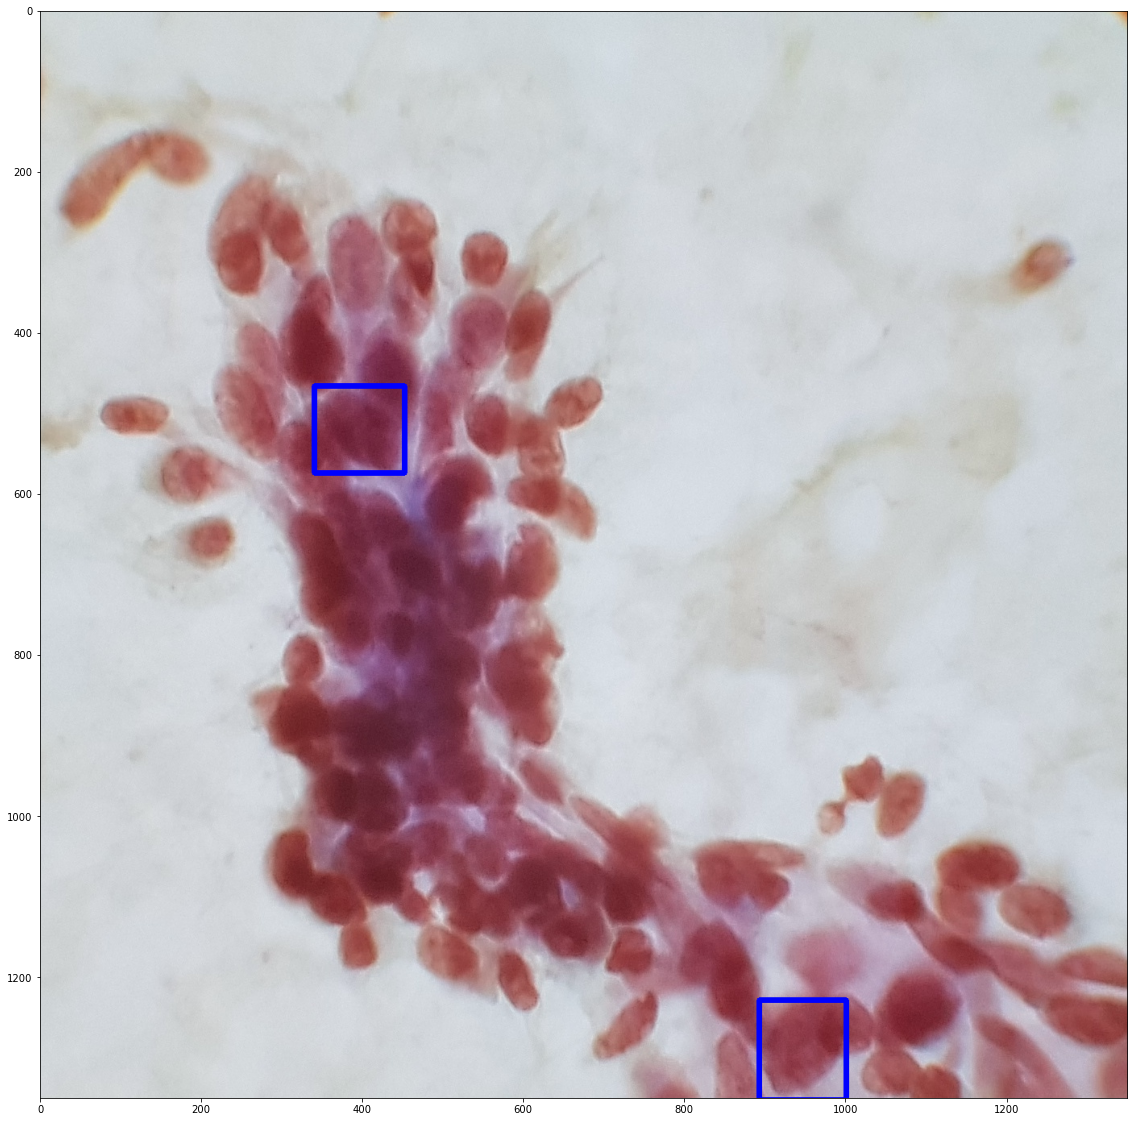

In [215]:
%matplotlib inline
import matplotlib.pyplot as plt

Image_number = 10800
image_list[Image_number]
print(image_list[Image_number])
img = draw_rect(image_list[Image_number]['image_id'], image_list[Image_number]['boxes'], image_list[Image_number]['label'],isCenter=True)
print('shape ',img.shape)
# bbox = [[2337, 487, 2483, 721], [2134, 521, 2242, 635]]
# img = draw_rect(image_list[Image_number]['image_id'], bbox, image_label=['ASCUS', 'ASCUS'], isCenter=False)
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [84]:
# img_ids = {x['image_id']:i for i,x in enumerate(image_list)}
# img_ids

In [223]:
def get_train_transforms():
    return A.Compose(
        [
#             A.OneOf(
#             [
#                 A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),      
#                 A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
#             ],
#             p=0.9),         
            #A.ToGray(p=0.01),         
            A.HorizontalFlip(p=0.5),         
            A.VerticalFlip(p=0.5),         
#             A.Resize(height=512, width=512, p=1),    
            A.Resize(height=512, width=512),
            A.Normalize(max_pixel_value=1),
#             #A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)
        ], 
        p=1.0,         
        bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
        )

In [224]:
class WheatDataset(Dataset):
    def __init__(self,image_list,transforms=None):
        self.images = image_list
        self.transforms = transforms
        self.img_ids = {x['image_id']:i for i,x in enumerate(image_list)}
        
    def get_indices(self,img_ids):
        return [self.img_ids[x] for x in img_ids]
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self,index):
        record = self.images[index]
        image_id = record['image_id']

        image = cv2.imread(image_id, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = record['boxes'] 
        
        labels =  np.zeros(len(boxes), dtype=np.int32)
        print(labels)
        print(boxes)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image  = sample['image']
            boxes  = sample['bboxes']
            labels = sample['labels']
#         print(labels)

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        ## detr uses center_x,center_y,width,height !!
        if len(boxes)>0:
            boxes = np.array(boxes)
            boxes[:,2:] /= 2
            boxes[:,:2] += boxes[:,2:]
        else:
            boxes = np.zeros((0,4))
    
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['label'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        
        return image, target, image_id

In [225]:
train_ds[350]

[0 0]
[[429 800  79  60]
 [697 841  67  79]]


(tensor([[[-2.0152, -2.0494, -2.0837,  ...,  1.4440,  1.4612,  1.4612],
          [-2.0665, -2.0837, -2.1008,  ...,  1.4440,  1.4440,  1.4783],
          [-2.0837, -2.1008, -2.0837,  ...,  1.3755,  1.3927,  1.4269],
          ...,
          [ 1.5468,  1.5468,  1.5468,  ...,  1.3927,  1.4269,  1.4269],
          [ 1.5639,  1.5468,  1.5125,  ...,  1.3927,  1.4440,  1.4612],
          [ 1.4612,  1.5125,  1.5639,  ...,  1.3584,  1.4098,  1.4612]],
 
         [[-1.9307, -1.9657, -2.0007,  ...,  1.6408,  1.6583,  1.6583],
          [-1.9832, -2.0007, -2.0182,  ...,  1.6408,  1.6408,  1.6758],
          [-2.0007, -2.0182, -2.0007,  ...,  1.5707,  1.5882,  1.6232],
          ...,
          [ 1.7283,  1.7283,  1.7283,  ...,  1.5182,  1.5532,  1.5532],
          [ 1.7458,  1.7283,  1.6933,  ...,  1.5182,  1.5707,  1.5882],
          [ 1.6408,  1.6933,  1.7458,  ...,  1.4832,  1.5357,  1.5882]],
 
         [[-1.6650, -1.6999, -1.7347,  ...,  1.8383,  1.8557,  1.8557],
          [-1.7173, -1.7347,

In [226]:
train_ds = WheatDataset(image_list,get_train_transforms())

In [227]:
def show_example(image,target,image_id=None):
    np_image = image.cpu().numpy().transpose((1,2,0))
    # unnormalize the image
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    #np_image = (np_image*255).astype(np.uint8)
    target = {k: v.cpu().numpy() for k, v in target.items()} 
    
    boxes = target['boxes']
    h,w,_ = np_image.shape
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        print('box ', box)
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        
    ax.set_axis_off()
    ax.imshow(np_image)
    print(np_image.shape)
    ax.set_title(image_id)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 0 0]
[[850 421  49  49]
 [890 526  51  49]
 [953 640  64  51]
 [768 706  62  49]
 [726 803  64  55]]
box  [180 168   9   9]
box  [164 208   9   9]
box  [138 252  12   9]
box  [208 277  11   9]
box  [224 314  12  10]
(512, 512, 3)


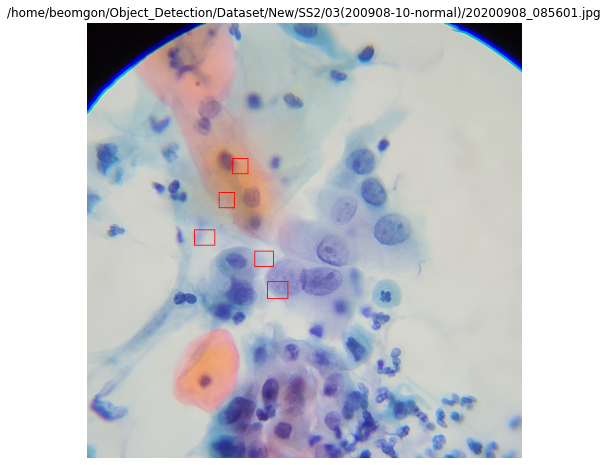

In [229]:
show_example(*train_ds[360])